In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import precision_score, recall_score

In [63]:
data = pd.read_csv('/content/dataset_extreme.csv')
features = ['feature1', 'feature2', 'feature3']
X = data[features].values
y = data['VPN'].values

In [64]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

val_acc_cv = []
val_f1_cv = []
val_true_labels = []
val_scores = []
val_precision_cv = []
val_recall_cv = []

In [65]:
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)

    y_pred_val = svm.predict(X_val)
    y_score_val = svm.predict_proba(X_val)[:, 1]

    val_acc_cv.append(accuracy_score(y_val, y_pred_val))
    val_f1_cv.append(f1_score(y_val, y_pred_val))
    val_precision_cv.append(precision_score(y_val, y_pred_val))
    val_recall_cv.append(recall_score(y_val, y_pred_val))

    val_true_labels.append(y_val)
    val_scores.append(y_score_val)

# Print average validation accuracy, F1-score, precision, and recall over all folds
print(f"Average Accuracy: {np.mean(val_acc_cv)}")
print(f"Average F1-score: {np.mean(val_f1_cv)}")
print(f"Average Precision: {np.mean(val_precision_cv)}")
print(f"Average Recall: {np.mean(val_recall_cv)}")

Average Accuracy: 0.9783950617283951
Average F1-score: 0.9680960547119966
Average Precision: 0.9592310929
Average Recall: 0.9777777777777779


In [66]:
# Compute ROC curve and AUC
tpr_cv = []
fpr_cv = []
auc_cv = []
mean_fpr = np.linspace(0, 1, 100)

for fold in range(n_splits):
    y_true_val = np.array(val_true_labels[fold])
    y_score_val = np.array(val_scores[fold])
    fpr, tpr, _ = roc_curve(y_true_val, y_score_val)
    auc_score = auc(fpr, tpr)

    tpr_interp = interp1d(fpr, tpr, kind='linear', fill_value=(0, 1), bounds_error=False)
    tpr_cv.append(tpr_interp(mean_fpr))
    auc_cv.append(auc_score)

In [67]:
# Compute the average TPR, FPR, and AUC over all folds
tpr_mean = np.mean(tpr_cv, axis=0)
auc_mean = np.mean(auc_cv)


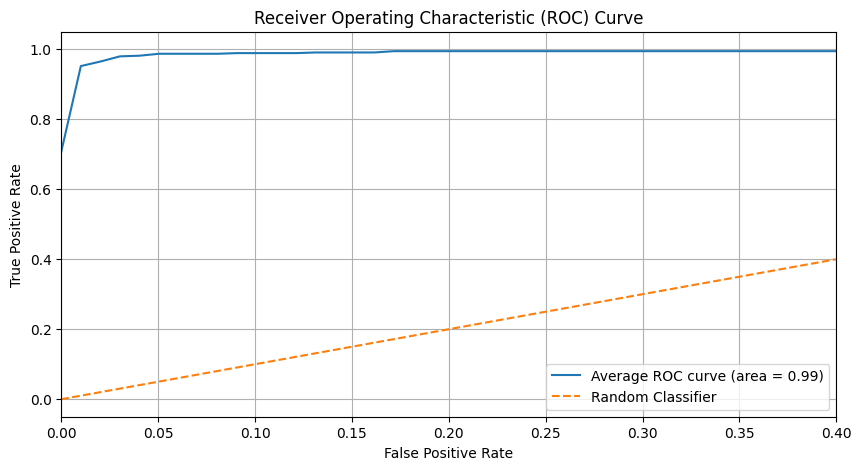

In [68]:
# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(mean_fpr, tpr_mean, label=f'Average ROC curve (area = {auc_mean:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.xlim(0, 0.4)
plt.show()

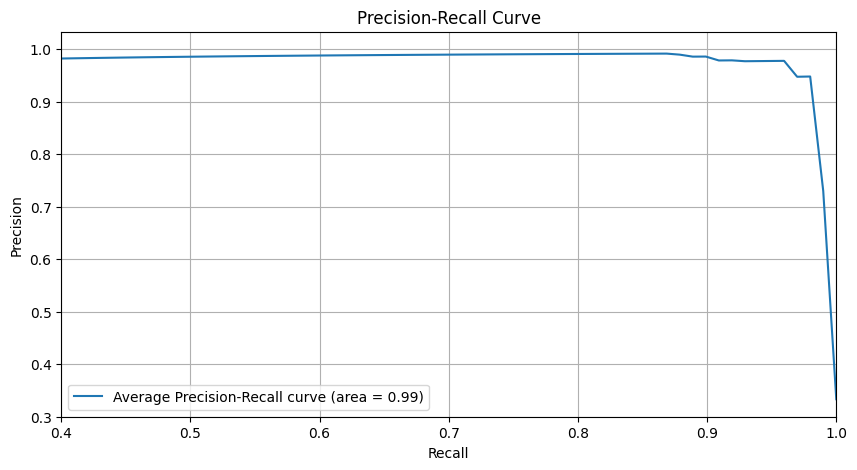

In [69]:
# Compute Precision-Recall curve and average precision
precision_cv = []
recall_cv = []
average_precision_cv = []
mean_recall = np.linspace(0, 1, 100)

for fold in range(n_splits):
    y_true_val = np.array(val_true_labels[fold])
    y_score_val = np.array(val_scores[fold])
    precision, recall, _ = precision_recall_curve(y_true_val, y_score_val)
    average_precision = average_precision_score(y_true_val, y_score_val)

    precision_interp = interp1d(recall[::-1], precision[::-1], kind='linear', fill_value=(0, 1), bounds_error=False)
    precision_cv.append(precision_interp(mean_recall))
    average_precision_cv.append(average_precision)

# Compute the average Precision and Recall over all folds
precision_mean = np.mean(precision_cv, axis=0)
average_precision_mean = np.mean(average_precision_cv)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))
plt.plot(mean_recall, precision_mean, label=f'Average Precision-Recall curve (area = {average_precision_mean:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.xlim(0.4, 1)
plt.show()